In [1]:
import scipy 
import pandas as pd
from glob import glob
import re
from collections import Counter
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


In [2]:
files_name = glob("./projet/*.txt")

In [3]:
dataframe_Fr = []
dataframe_En = []
for name in files_name:
    if ("Fr") in name:
        dataframe_Fr.append(open(name, "r").read())
    else:
        dataframe_En.append(open(name, "r").read())
dataframe_ = []
for name in files_name:
    dataframe_.append(open(name, "r").read())

In [4]:
regex = re.compile(r"[\':,.?;«!\n\r\t()0123456789#/]")
def Nettoyage(data):
    # Netoyage de data 
    for i in range(0,len(data)):
        data[i]=regex.sub(" ", data[i])
        data[i]=data[i].replace("é","e")\
                        .replace("è","e")\
                        .replace("ê","e")\
                        .replace("à","a")\
                        .replace("ô","o")\
                        .replace("î","i")\
                        .replace("â","a")\
                        .replace("œ'","oe")\
                        .replace("û'","u")\
                        .replace("ù","u")\
                        .replace("ç","c")\
                        .replace('"',"")\
                        .replace('-'," ")                                                                    
        data[i]=data[i].lower()
    return data    

def conversion_to_string(text):
    l = []
    for x in (text):
        for s in x:
            l.append(s)
    return l

def conversion_ascii(text):
    S = []
    for x in text:
        if (x != ' '):
            S.append(ord(x)- 97)
        else:
            S.append(26)
    return S

def find_erro_alphabets(text_num, text_origin):
    erro = []
    erro_num = []
    if any(x < 0 or x > 26 for x in text_num):
        for i in range (len(text_num)):
            if text_num[i]< 0 or text_num[i] > 26:
                erro_num.append(text_num[i])
                erro.append(text_origin[i])
        print (erro_num)
        print (erro)
    else:
         print ('No special letter')
def find_words (unique_words, corpus):
    remove_words = []
    for x in set(corpus):
        if x not in (unique_words):
            remove_words.append(x)
    return remove_words

def remove_word (unique_words, corpus):
    unique_corpus = set(corpus)
    i = 1
    remove_ = []
    while (i > 0) or (len(remove_) > 0):
        i -= 1
        remove_words = find_words(unique_words, corpus)
        for x in corpus:
            if x in remove_words:
                corpus.remove(x)
        remove_ = find_words(unique_words, corpus)
    return corpus 

dataframe_En, dataframe_Fr = Nettoyage(dataframe_En), Nettoyage(dataframe_Fr)


## Ex3  Chaine de Markov

### Question 1 Estimation des parametres de chaine de markov

Suppose the labels were known, we can estimate the transition matrix and emission matrix by calculating the frequency.

In [5]:
#X_fr and X_en 
# with y = 0 for english word and y = 1 for french word 
# we keep only word length >= 2

def unique_carcter(text):
    (unique_w, counts_w )=np.unique(text, return_counts = True)
    counts_w_nor = counts_w/counts_w.sum()
    dic_freq = dict(zip(unique_w, counts_w_nor))
    return dic_freq
dataframe_En, dataframe_Fr = Nettoyage(dataframe_En), Nettoyage(dataframe_Fr)
all_words_tmp = []
all_words_en = []
for i in range (len(dataframe_En)):
    all_words_tmp += dataframe_En[i].split()
for x in all_words_tmp:
    if len(x) > 1:
        all_words_en.append(x)
    
all_words_tmp = []
all_words_fr = []
for i in range (len(dataframe_Fr)):
    all_words_tmp += dataframe_Fr[i].split()
for x in all_words_tmp:
    if len(x) > 1:
        all_words_fr.append(x)

all_letter_en, all_letter_fr = conversion_to_string(all_words_en), conversion_to_string(all_words_fr)
y_en, y_fr = [0] * len(all_letter_en), [1] * len(all_letter_fr)

### Question 2 construire notre estimateur

In order to build our predictor, we have to calculte the probabity of the oberservation giver the model.
We can build the model as follow:
- we find the index of which alpha (the result of forward calcution) is biggest. e.g argmax (alapha(i))
- we compare it to the correpondent index y label (last one) 

In [6]:
# the forward pass calcalte the probability of the observation given the parameter of our "hidden"
#markov model. In our cases, we will train our data on an train data set, and we may not have 
#encounter all the vocabulairy in the train set, we have to take care of thoses particular cases.
def forward_pass(Pi, A, B, k, text):
        tot_num_ = len(text)
        c_ = np.zeros(tot_num_)
        Aalpha_ = np.zeros((k, tot_num_))
        for i in range(k):
            try:
                a = B[text[0]][i]
            except KeyError:
                a = 0
            Aalpha_[i, 0] = Pi[i] * a
            c_[0] += Aalpha_[i, 0]
        if c_[0] != 0:
                c_[0] = 1 / (c_[0])

        for i in range(0, k):
            Aalpha_[i, 0] = Aalpha_[i, 0] * c_[0] # scaling
            #print(self.Aalpha_[:, 0])
            # Recursion
        for t in range(1, tot_num_):
            c_[t] = 0
            for i in range(k):
                for j in range(k):
                    Aalpha_[i, t] = Aalpha_[i, t] + Aalpha_[j, t - 1] * A[j, i]
                try:
                    a = B[text[t]][i]
                except KeyError:
                    a = 0
                Aalpha_[i, t] = Aalpha_[i, t] * a
                c_[t] += Aalpha_[i, t]
            if c_[t] != 0:
                c_[t] = 1 / (c_[t])
            for i in range(k):
                Aalpha_[i, t] = Aalpha_[i, t] * c_[t]  # scaling
        return (Aalpha_)
    
def predictor(text_train, y_train, text_test, y_test):
    (Pi, A, B) = parameter_estimation(text_train, y_train)
    Alpha = forward_pass(Pi, A, B, 2, text_test)
    y_pred = []
    for i in range (len(Alpha[0])):
        y_pred.append(np.argmax(Alpha[:, i]))
    print("Prediction of last obeservation =", y_pred[-1], "The expected value = ", y_test[-1], sep = '\n')
    ide = 0
    for i in range(len(y_pred)):
        if y_pred[i] == y_test[i]:
            ide +=1
    print('the proportion of correct prediciton is = {}'.format(ide/len(y_pred)))
    return (y_pred, y_test)

### Question 3  evaluation des resultat 

In [7]:
New_text = [all_letter_en + all_letter_fr, y_en + y_fr]
def split_size(s, text):
    X_train, X_test, y_train, y_test = train_test_split(text[0], text[1], 
                                                                    test_size=s, random_state=42)
    print('split size = ', s)
    y_pred, y_test = predictor(X_train, y_train, X_test, y_test)
    (Pi, A, B) = parameter_estimation(X_train, y_train)
    alpha = forward_pass(Pi, A, B, 2, X_test)
    #return (y_pred, y_test)

We can conclude this is an good predictor

## Exo 4 Viterbi

### Q1 creation de list

In [8]:
# random list for french word
randomlist_fr = np.random.choice(len(all_letter_fr))
randomlist_en = np.random.choice(len(all_letter_en))

In [9]:
def random_choice (trans_AA, trans_BB, words_fr, words_en):
    random_word= []
    random_y = []
    t = 0
    i = 0
    j = 0
    while len(random_word) < 1000 and t <1:
        s = np.random.uniform(0,1)
        randomlist_fr = np.random.choice(len(words_fr))
        randomlist_en = np.random.choice(len(words_en)) 
        
        if s >=trans_AA and  i == 0 and (j + len(conversion_to_string(all_words_fr[randomlist_fr]))<=1000):
            i = 0
            j+= len(conversion_to_string(all_words_fr[randomlist_fr]))
            for x in conversion_to_string(all_words_fr[randomlist_fr]):
                random_word.append(x)
                random_y.append(1)
        elif s <trans_AA and  i == 0 and (j+ len(conversion_to_string(all_words_en[randomlist_en]))<=1000):
            i = 1
            j+=  len(conversion_to_string(all_words_en[randomlist_en]))
            for x in conversion_to_string(all_words_en[randomlist_en]):
                random_word.append(x)
                random_y.append(0)
        elif s >=trans_BB and  i == 1 and (j+ len(conversion_to_string(all_words_fr[randomlist_fr]))<=1000):
            i = 0
            j+= len(conversion_to_string(all_words_fr[randomlist_fr]))
            for x in conversion_to_string(all_words_fr[randomlist_fr]):
                random_word.append(x)
                random_y.append(1)
        elif s <trans_BB and  i == 1 and (j+ len(conversion_to_string(all_words_en[randomlist_en]))<=1000):
            i = 1
            j+= len(conversion_to_string(all_words_en[randomlist_en]))
            for x in conversion_to_string(all_words_en[randomlist_en]):
                random_word.append(x)
                random_y.append(0)
        elif (j + len(conversion_to_string(all_words_en[randomlist_en])) >=1000) or (j + len(conversion_to_string(all_words_fr[randomlist_fr])) >=1000):
            t +=1
    return random_word, random_y

In [10]:
random_word, random_y = random_choice (0.6, 0.3, all_words_fr, all_words_en)
len(random_y)

994

### Q2 Estimation avec viterbi

In [11]:
alphabet =['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',' ']
Nom = [x.upper() for x in alphabet]


def Transitiontexte(texte, alphabet):
    Fr=np.zeros((27,27)) 
    for n1 in range(len(alphabet)):
        Lidx=[]
        idx=0
        compt=0
        while(texte.find(alphabet[n1],idx,len(texte)-1)!=-1):
            idx=texte.find(alphabet[n1],idx,len(texte))
            Lidx.append(idx)
            compt=compt+1
            idx=idx+1   
        res = Counter(texte[Lidx[idx]+1] for idx in range(len(Lidx)))
        for n2 in range(len(alphabet)):
            try:
                Fr[n1,n2]=res[alphabet[n2]]+1 #on ajoute 1 pour ne jamais avoir de 0 
                pass
            except KeyError  :
                Fr[n1,n2]=1 
    return Fr

def Mattrans_sanslog(data,alphabet, Nom):
    N,=np.shape(data)
    Fr=np.zeros((27,27))
    for num in range(0,N):
        Fr=Fr+Transitiontexte(data[num], alphabet)
        
    for li in range (len(alphabet)):
        somme=Fr[li,:].sum()
        Fr[li,:]=Fr[li,:]/somme
    return pd.DataFrame(data=Fr,columns=Nom,index=Nom)

def value_emmision(trans_):
    value = []
    tot = 0
    for col in (trans_.columns):
        value.append(trans_[col].sum())
        tot += trans_[col].sum()
    value /=  tot
    return (value)

def B_emission(data_fr, data_en, alp, nom_col):
    trans_fr = Mattrans_sanslog(dataframe_Fr, alp, nom_col)
    trans_en = Mattrans_sanslog(dataframe_En, alp, nom_col)
    val_fr = value_emmision(trans_fr)
    val_en = value_emmision(trans_en)
    B_emi = pd.DataFrame(data = (val_fr, val_en), columns= nom_col)
    return B_emi

trans_fr = Mattrans_sanslog(dataframe_Fr, alphabet, Nom)
trans_en = Mattrans_sanslog(dataframe_En, alphabet, Nom)
B_vit = B_emission(dataframe_Fr, dataframe_En, alphabet, Nom)

In [12]:
class MyHMM_final():
    """docstring for  MyHMM_final
    import numpy for random seed and np array, log calculation...
    If emission, transmission or initial distrubution are not given, 
    we automatically generate row stochastic matrix correspond to the number of states: k and the number of parameter: M
    M is calculted by the number of features
    forward_pass : calculte the
    backward_pass :
    gamma 
    model_ab : recaluclation of transition matrix and emission matrix with alpha, beta and gamma calculted before
    
    """
    def __init__(self, k, M=None, unique_word=None, seed=42, A=None, B=None, pi=None, max_iter=10):
        '''
        k_ number of states
        '''
        self.k_ = k
        self.max_iter_ = max_iter
        self.A_ = A
        self.B_ = B
        self.Pi_ = pi
        self.Aalpha_ = None
        self.Beta_ = None
        self.GammaB_ = None
        self.Gamma_ = None
        self.tot_num_ = 0
        self.c_ = None
        self.eps_ = 1e-12
        self.unique_word_ = unique_word
        self.M_ = len(self.unique_word_)
        self.seed_ = seed
        np.random.seed(self.seed_)

    def forward_pass(self, text):
        self.c_[0] = 0
        for i in range(0, self.k_):
            self.Aalpha_[i, 0] = self.Pi_[i] * self.B_[i, self.unique_word_[text[0]]]
            self.c_[0] += self.Aalpha_[i, 0]
        self.c_[0] = 1 / self.c_[0]
        for i in range(0, self.k_):
            self.Aalpha_[i, 0] = self.Aalpha_[i, 0] * self.c_[0] # scaling
            #print(self.Aalpha_[:, 0])
            # Recursion
        for t in range(1, self.tot_num_):
            self.c_[t] = 0
            for i in range(self.k_):
                self.Aalpha_[i, t]  = 0
                for j in range(self.k_):
                    self.Aalpha_[i, t] = self.Aalpha_[i, t] + self.Aalpha_[j, t - 1] * self.A_[j, i]
                self.Aalpha_[i, t] = self.Aalpha_[i, t] * self.B_[i, self.unique_word_[text[t]]]
                self.c_[t] += self.Aalpha_[i, t]
            self.c_[t] = 1 / self.c_[t]
            for i in range(self.k_):
                self.Aalpha_[i, t] = self.Aalpha_[i, t] * self.c_[t]  # scaling

    def backward_pass(self, text):
        # initialisation
        #print(self.c_)
        for i in range(self.k_):
            self.Beta_[i, -1] = 1 * self.c_[-1]
        #print('beta T-1')
        #print(self.Beta_[:, -1])
        # Recursion
        for t in range(self.tot_num_ - 2, -1, -1):
            for i in range(self.k_):
                self.Beta_[i, t] = 0
                for j in range(self.k_):
                    self.Beta_[i, t] = self.Beta_[i, t] + self.A_[i, j] * self.B_[j, self.unique_word_[text[t+1]]] * self.Beta_[j, t + 1]
                self.Beta_[i, t] = self.Beta_[i, t] * self.c_[t]
        #print('Beta')
        #print(self.Beta_)
        #print("alpha", self.Aalpha_, sep = '\n')
        
    def gamma_estimation(self, text):
        for t in range(0, self.tot_num_ - 1):
            for i in range(self.k_):
                self.Gamma_[i, t] = 0
                for j in range(self.k_):
                    self.GammaB_[t][i, j] = self.Aalpha_[i, t] * self.A_[i, j] * self.B_[j, self.unique_word_[text[t+1]]] * self.Beta_[j, t + 1]
                    self.Gamma_[i, t] += self.GammaB_[t][i, j]
        for i in range(self.k_):
            self.Gamma_[i, -1] = self.Aalpha_[i, -1]
        #print("Gamma_")
        #print(self.Gamma_)
        #print(self.GammaB_[0])

    def model_ab(self, text):
        # restiamte initial distrubution 
        for i in range(self.k_):
            self.Pi_[i] = self.Gamma_[i, 0]
        # restiamte A
        for i in range(self.k_):
            denom = 0 
            for t in range(0, self.tot_num_ - 1):
                denom += self.Gamma_[i, t]
            #print(denom)
            for j in range(self.k_):
                numer = 0
                for t in range(0, self.tot_num_ - 1):
                    numer += self.GammaB_[t][i, j]
                #print('numer')
                #print(numer)
                self.A_[i, j] = numer / denom
        # restimate B
        for i in range(self.k_):
            denom = 0
            for t in range(0, self.tot_num_):
                denom += self.Gamma_[i, t]
            for j in range(self.M_):
                numer = 0
                for t in range(0, self.tot_num_):
                    if (self.unique_word_[text[t]] == j):
                        numer += self.Gamma_[i, t]
                self.B_[i, j] = numer / denom
        return self
    
    def logproba(self):
        logprob = 0
        for t in range(self.tot_num_):
            logprob += np.log(self.c_[t])
        new_log_prob = -logprob
        return (new_log_prob)



    def fit(self, text):
        self.tot_num_ = len(text)
        if (self.A_ is None):
            self.A_ = np.random.dirichlet(np.ones(self.k_), size=self.k_)
        if (self.B_ is None):
            self.B_ = np.random.dirichlet(np.ones(self.M_), size=self.k_)
        if (self.Pi_ is None):
            self.Pi_ = np.random.dirichlet(np.ones(self.k_))
        self.Gamma_ = np.zeros((self.k_, self.tot_num_))     # row stochastic matrix
        self.GammaB_ = np.zeros((self.tot_num_, self.k_, self.k_))
        self.Beta_ = np.zeros((self.k_, self.tot_num_))
        self.c_ = np.zeros(self.tot_num_)
        self.Aalpha_ = np.zeros((self.k_, self.tot_num_))
        ite = 0
        print("Initial distrubution =", self.Pi_, "Transition matrix = ", self.A_, "Emission matrix = ", self.B_ , sep = '\n')

        while (ite <= self.max_iter_):
            print('-------------------------------------------------------', 'number of recrusion :' + str(ite), sep = '\n')
            self.forward_pass(text)
            self.backward_pass(text)
            self.gamma_estimation(text)
            self.model_ab(text)
            if (ite % 10 == 0 or ite == self.max_iter_):
                print("Initial distrubution =", self.Pi_, "Transition matrix = ", self.A_, "Emission matrix = ", self.B_ , sep = '\n')
                #print(self.B_[0].sum())
            log_prob = self.logproba()
            ite += 1
            print("log proba = " + str(log_prob))
        return self

    def viterbi(self, text):
        self.tot_num_ = len(text)
        # Initialize D and E matrices
        print("Initial distrubution =", self.Pi_, "Transition matrix = ", self.A_, "Emission matrix = ", self.B_ , sep = '\n')
        D = np.zeros((self.k_, self.tot_num_))
        E = np.zeros((self.k_, self.tot_num_ - 1))
        D[:, 0] = np.multiply(self.Pi_, self.B_[:, 0])

        # Compute D and E in a nested loop
        for t in range(1, self.tot_num_):
            for i in range(self.k_):
                temp_product = np.multiply(self.A_[:, i], D[:, t-1])
                a = 0
                try:
                    a =  self.B_[i, self.unique_word_[text[t]]]
                except KeyError:
                    a = 0
                D[i, t] = np.max(temp_product) * a
                E[i, t-1] = np.argmax(temp_product)

        # Backtracking
        S_opt = np.zeros(self.tot_num_)
        S_opt[-1] = np.argmax(D[:, -1])
        for n in range(self.tot_num_ - 2, 0, -1):
            S_opt[n] = E[int(S_opt[n+1]), n]

        return S_opt, D, E

For the viterbi model, we will have Pi as the starting matrix, A as the transition matrix between different text and B the emission matrix as the previous A matrix in the algoritheme de excercise 3.

In [13]:
alphabet =['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',' ']
Nom = [x.upper() for x in alphabet]
trans_fr = Mattrans_sanslog(dataframe_Fr, alphabet, Nom)
trans_en = Mattrans_sanslog(dataframe_En, alphabet, Nom)

def value_emmision(trans_):
    value = []
    tot = 0
    for col in (trans_.columns):
        value.append(trans_[col].sum())
        tot += trans_[col].sum()
    value /=  tot
    return (value)

def B_emission(data_fr, data_en, alp, nom_col):
    trans_fr = Mattrans_sanslog(dataframe_Fr, alp, nom_col)
    trans_en = Mattrans_sanslog(dataframe_En, alp, nom_col)
    val_fr = value_emmision(trans_fr)
    val_en = value_emmision(trans_en)
    B_emi = pd.DataFrame(data = (val_fr, val_en), columns= nom_col)
    return B_emi


B_vit = B_emission(dataframe_Fr, dataframe_En, alphabet, Nom)
Pi_vit = [0.5, 0.5]
A_vit = np.array(((0.3, 0.7),(0.4, 0.6)))
B_vit = np.array(B_vit)
alp_key = list(alphabet)
alp_values = list(range(0,len(alp_key)))
alp = dict(zip(alp_key, alp_values))

viter = MyHMM_final(2, M=None, unique_word=alp, seed=42, A=A_vit, B=B_vit, pi=Pi_vit)
S_opt, D, E = viter.viterbi(random_word)
print(S_opt)
culm = 0
for x in range (len(random_y)):
    if S_opt[x] == random_y[x]:
        culm += 1
print("percentage of correct prediction is  =", culm/1000)

Initial distrubution =
[0.5, 0.5]
Transition matrix = 
[[0.3 0.7]
 [0.4 0.6]]
Emission matrix = 
[[0.07290517 0.01766753 0.02164148 0.02206295 0.12337225 0.01789952
  0.01755157 0.01988425 0.0550326  0.01576993 0.01461408 0.03759949
  0.02527435 0.04193008 0.05573004 0.02172109 0.01680722 0.04660619
  0.04671795 0.03744464 0.05980955 0.01871857 0.01450059 0.01602231
  0.01529205 0.01482435 0.13260019]
 [0.05183054 0.01975118 0.02140749 0.03035579 0.09086601 0.02087191
  0.02267057 0.03881766 0.04675269 0.01653527 0.02160607 0.0340704
  0.02356374 0.04481915 0.06729312 0.02128895 0.01619491 0.0382408
  0.03402711 0.04531267 0.03514911 0.01926851 0.02147123 0.01631143
  0.02963006 0.01652825 0.15536538]]
[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.

After certain step, transition matrix become stationannry, and we have only 0 after that.

In [14]:
"""X_train, X_test, y_train, y_test = train_test_split(New_text[0], New_text[1], test_size=0.4, random_state=42)
print('split size = ', )
y_pred, y_test = predictor(X_train, y_train, X_test, y_test)
(Pi, A, B) = parameter_estimation(X_train, y_train)
B = B.reindex(sorted(B.columns), axis=1)
B =  np.array(B)
def random_(words, y):
    random_word= []
    random_y = []
    for i in range(1000):
        randoml = np.random.choice(len(words))
        random_word.append(words[randoml])
        random_y.append(y[randoml])
    return (random_word, random_y)
random_word, random_y = random_(X_train, y_train)
viter = MyHMM_final(2, M=None, unique_word=dic_trian, seed=42, A=A, B=B, pi=Pi)
S_opt, D, E = viter.viterbi(random_word)
ide = 0
for i in range(len(random_y)):
        if random_y[i] == S_opt[i]:
            ide +=1
ide/1000"""

"X_train, X_test, y_train, y_test = train_test_split(New_text[0], New_text[1], test_size=0.4, random_state=42)\nprint('split size = ', )\ny_pred, y_test = predictor(X_train, y_train, X_test, y_test)\n(Pi, A, B) = parameter_estimation(X_train, y_train)\nB = B.reindex(sorted(B.columns), axis=1)\nB =  np.array(B)\ndef random_(words, y):\n    random_word= []\n    random_y = []\n    for i in range(1000):\n        randoml = np.random.choice(len(words))\n        random_word.append(words[randoml])\n        random_y.append(y[randoml])\n    return (random_word, random_y)\nrandom_word, random_y = random_(X_train, y_train)\nviter = MyHMM_final(2, M=None, unique_word=dic_trian, seed=42, A=A, B=B, pi=Pi)\nS_opt, D, E = viter.viterbi(random_word)\nide = 0\nfor i in range(len(random_y)):\n        if random_y[i] == S_opt[i]:\n            ide +=1\nide/1000"

It is almost as bad as outputting only 0, because we chose the random split as 0.6. We can now chose a database with the know word (words in test set to see if we can do better).

In [15]:
def plot_emission(B, index_ax, plot_title, fig_size):
    plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
    ind = np.arange(len(B[0])) 
    width = 0.35
    fig, ax = plt.subplots(figsize=fig_size)
    ax.set_ylabel('probability')
    ax.bar(ind - width/2, width = 0.5, height = np.log(1+B[0]), label = 'group 0')
    ax.bar(ind + width/2, width = 0.5, height = np.log(1+B[1]), label = 'group 1')
    ax.set_title(plot_title)
    ax.set_xticks(ind)
    ax.set_xticklabels(index_ax, rotation=90)
    ax.legend()

In [16]:
# data cleaning alphabet_ version
dataframe_letter = Nettoyage(dataframe_)
all_str= conversion_to_string(dataframe_letter)
dia_alp_key = sorted(list(set(all_str)))
dic_alp_values = list(range(0,len(dia_alp_key)))
dic_alp = dict(zip(dia_alp_key, dic_alp_values))

## Exo5 Algorithme de Baum-Welch

### Q1 Baum-Welch algorithme is computed in exo4 question 2

### Q2 sur le text viterbu avec les initialisation des parametres de l'excercies 3

In [17]:
viter = MyHMM_final(2, M=None, unique_word=alp, seed=42, A=A_vit, B=B_vit, pi=Pi_vit, max_iter= 101)

viter.fit(random_word)

Initial distrubution =
[0.5, 0.5]
Transition matrix = 
[[0.3 0.7]
 [0.4 0.6]]
Emission matrix = 
[[0.07290517 0.01766753 0.02164148 0.02206295 0.12337225 0.01789952
  0.01755157 0.01988425 0.0550326  0.01576993 0.01461408 0.03759949
  0.02527435 0.04193008 0.05573004 0.02172109 0.01680722 0.04660619
  0.04671795 0.03744464 0.05980955 0.01871857 0.01450059 0.01602231
  0.01529205 0.01482435 0.13260019]
 [0.05183054 0.01975118 0.02140749 0.03035579 0.09086601 0.02087191
  0.02267057 0.03881766 0.04675269 0.01653527 0.02160607 0.0340704
  0.02356374 0.04481915 0.06729312 0.02128895 0.01619491 0.0382408
  0.03402711 0.04531267 0.03514911 0.01926851 0.02147123 0.01631143
  0.02963006 0.01652825 0.15536538]]
-------------------------------------------------------
number of recrusion :0
Initial distrubution =
[0.49766293963633523, 0.5023370603636719]
Transition matrix = 
[[0.31623313 0.68376687]
 [0.41873754 0.58126246]]
Emission matrix = 
[[0.1000863  0.0157203  0.0171297  0.02830335 0.16953

log proba = -2774.9285719202694
-------------------------------------------------------
number of recrusion :38
log proba = -2774.704282310285
-------------------------------------------------------
number of recrusion :39
log proba = -2774.5485513674557
-------------------------------------------------------
number of recrusion :40
Initial distrubution =
[6.908642751847849e-149, 1.0000000000000135]
Transition matrix = 
[[0.12020575 0.87979425]
 [0.6406153  0.3593847 ]]
Emission matrix = 
[[2.02987579e-01 5.16625120e-03 6.91181760e-05 2.12719378e-02
  3.42705156e-01 2.24859875e-05 1.89677412e-02 4.45998915e-05
  1.15366711e-01 3.63917356e-04 1.30357083e-02 9.05192272e-05
  2.05069770e-11 7.79039969e-06 1.66932619e-01 1.66727277e-02
  2.37401454e-02 1.20462522e-08 2.68397863e-02 2.79235217e-02
  1.31400617e-02 4.42077834e-17 2.45129604e-03 2.19628954e-03
  4.02472840e-06 1.37736805e-22 0.00000000e+00]
 [4.22593282e-06 2.75293333e-02 3.12395001e-02 4.88342522e-02
  6.08081057e-03 2.60584

log proba = -2773.889881503779
-------------------------------------------------------
number of recrusion :77
log proba = -2773.889454080208
-------------------------------------------------------
number of recrusion :78
log proba = -2773.8890499593326
-------------------------------------------------------
number of recrusion :79
log proba = -2773.8886672588915
-------------------------------------------------------
number of recrusion :80
Initial distrubution =
[0.0, 1.000000000000016]
Transition matrix = 
[[0.11598902 0.88401098]
 [0.62741716 0.37258284]]
Emission matrix = 
[[2.06038538e-01 5.28056603e-03 9.75928015e-09 1.95697417e-02
  3.47796807e-01 9.58097959e-08 1.81127272e-02 4.17132497e-10
  1.16870081e-01 3.67163406e-03 1.36822460e-02 2.29726009e-08
  2.06605958e-33 2.38698238e-13 1.69678796e-01 1.68446919e-02
  2.42398281e-02 1.06886252e-23 2.40255257e-02 2.51755958e-02
  5.25953958e-03 1.16659911e-48 1.56447961e-03 2.18907334e-03
  2.12129297e-17 1.88859603e-69 0.00000000e

<Figure size 1200x640 with 0 Axes>

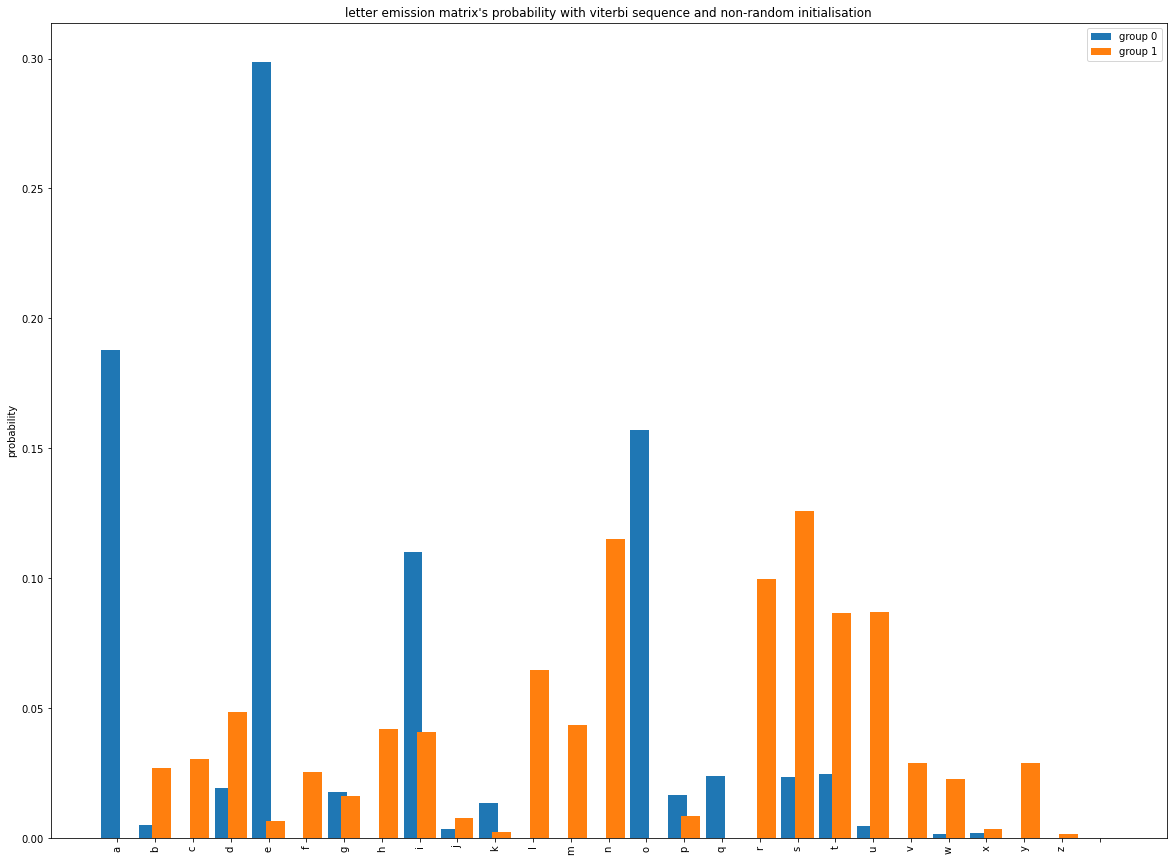

In [18]:
plot_emission(viter.B_, viter.unique_word_.keys(), 
              "letter emission matrix's probability with viterbi sequence and non-random initialisation"
              , fig_size = (20,15))

We can see the 2 group distinction is not really effective in an language point of view. The division is made mainly between consonant and vowel. Which is logic, because in both french and english, we have the same vowels.

And it does not make sense to look at the change between each symbols at letter level. Because markov model is a sequential model, and language is regroup by words not letters.

We will do an other model with words. This time each obeservation is a word.

### Q4 car Q3 et Q2 c'est la meme, sequence aleatoire avec initialisation random

In [19]:
viter_rand = MyHMM_final(2, M=None, unique_word=alp, max_iter= 101)

viter_rand.fit(random_word)

Initial distrubution =
[0.10523076 0.89476924]
Transition matrix = 
[[0.13487081 0.86512919]
 [0.59055148 0.40944852]]
Emission matrix = 
[[0.00874343 0.00874196 0.00308443 0.10367028 0.04737472 0.06346563
  0.00107211 0.18059328 0.09208274 0.01230332 0.01034414 0.01044375
  0.01869839 0.03834627 0.029151   0.01774321 0.04878134 0.00774394
  0.01780984 0.02351912 0.03138796 0.07927397 0.01148107 0.03721749
  0.0462625  0.00245171 0.04821239]
 [0.00603072 0.0021697  0.09592089 0.10872489 0.05329851 0.01171841
  0.00331524 0.03718376 0.01871173 0.00419826 0.02204887 0.00112878
  0.07742935 0.00965947 0.03503886 0.01204932 0.02367988 0.02552215
  0.00659287 0.11266589 0.04813468 0.09048266 0.07264664 0.02938747
  0.08223598 0.00298875 0.00703627]]
-------------------------------------------------------
number of recrusion :0
Initial distrubution =
[0.13338715 0.86661285]
Transition matrix = 
[[0.16185826 0.83814174]
 [0.6207664  0.3792336 ]]
Emission matrix = 
[[0.08714231 0.02881289 0.00

log proba = -2789.1039840973767
-------------------------------------------------------
number of recrusion :35
log proba = -2786.4790803568458
-------------------------------------------------------
number of recrusion :36
log proba = -2784.2495431332195
-------------------------------------------------------
number of recrusion :37
log proba = -2782.3533089479542
-------------------------------------------------------
number of recrusion :38
log proba = -2780.7249476164125
-------------------------------------------------------
number of recrusion :39
log proba = -2779.3257476707304
-------------------------------------------------------
number of recrusion :40
Initial distrubution =
[3.84821117e-92 1.00000000e+00]
Transition matrix = 
[[0.13862044 0.86137956]
 [0.65434343 0.34565657]]
Emission matrix = 
[[1.89423542e-01 1.42429627e-02 2.01653797e-03 2.07902623e-02
  3.31337095e-01 4.08209086e-03 1.88660444e-02 1.12141779e-03
  1.37608714e-01 5.69789316e-03 1.31743893e-02 1.51516607e

log proba = -2773.945459498002
-------------------------------------------------------
number of recrusion :74
log proba = -2773.943006177252
-------------------------------------------------------
number of recrusion :75
log proba = -2773.9407322799157
-------------------------------------------------------
number of recrusion :76
log proba = -2773.938622755635
-------------------------------------------------------
number of recrusion :77
log proba = -2773.936664375565
-------------------------------------------------------
number of recrusion :78
log proba = -2773.934845402948
-------------------------------------------------------
number of recrusion :79
log proba = -2773.933155335013
-------------------------------------------------------
number of recrusion :80
Initial distrubution =
[0. 1.]
Transition matrix = 
[[0.11163674 0.88836326]
 [0.61858345 0.38141655]]
Emission matrix = 
[[2.08360563e-01 5.30436103e-03 2.66678005e-07 1.88577819e-02
  3.50738747e-01 7.18226730e-05 1.7828

<Figure size 1200x640 with 0 Axes>

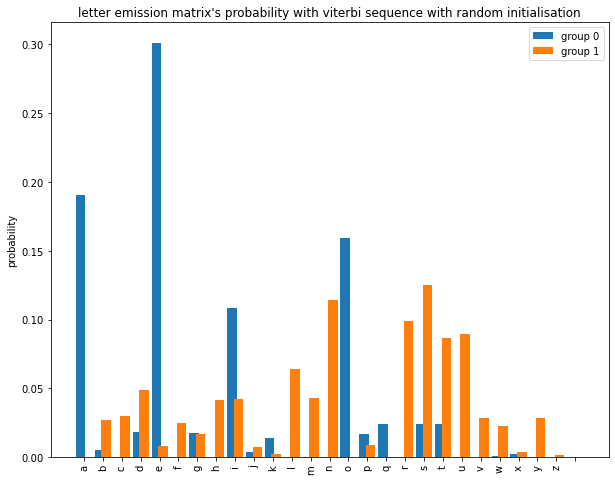

<Figure size 1200x640 with 0 Axes>

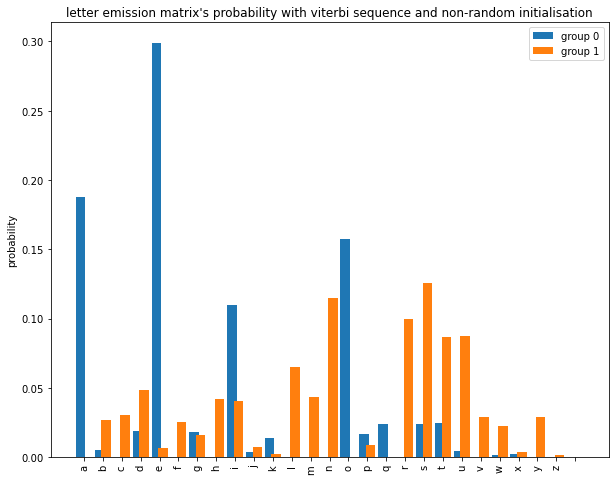

In [20]:
plot_emission(viter_rand.B_, viter_rand.unique_word_.keys(), 
              "letter emission matrix's probability with viterbi sequence with random initialisation"
              , fig_size = (10,8))
plot_emission(viter.B_, viter.unique_word_.keys(), 
              "letter emission matrix's probability with viterbi sequence and non-random initialisation"
              , fig_size = (10,8))

In [21]:
#X_fr and X_en 
# with y = 0 for english word and y = 1 for french word 
# we keep only word length >= 2

def unique_carcter(text):
    (unique_w, counts_w )=np.unique(text, return_counts = True)
    counts_w_nor = counts_w/counts_w.sum()
    dic_freq = dict(zip(unique_w, counts_w_nor))
    return dic_freq
dataframe_En, dataframe_Fr = Nettoyage(dataframe_En), Nettoyage(dataframe_Fr)
all_words_tmp = []
all_words_en = []
for i in range (len(dataframe_En)):
    all_words_tmp += dataframe_En[i].split()
for x in all_words_tmp:
    if len(x) > 1:
        all_words_en.append(x)
    
all_words_tmp = []
all_words_fr = []
for i in range (len(dataframe_Fr)):
    all_words_tmp += dataframe_Fr[i].split()
for x in all_words_tmp:
    if len(x) > 1:
        all_words_fr.append(x)

all_letter_en, all_letter_fr = conversion_to_string(all_words_en), conversion_to_string(all_words_fr)
y_en, y_fr = [0] * len(all_letter_en), [1] * len(all_letter_fr)

In [22]:
# data cleaning words_ version
dataframe_En, dataframe_Fr = Nettoyage(dataframe_En), Nettoyage(dataframe_Fr)
vectorizer = TfidfVectorizer(max_features = 50, lowercase=True)
vectorizer.fit_transform(dataframe_En)
unique_word_en = vectorizer.get_feature_names()
vectorizer.fit_transform(dataframe_Fr)
unique_word_fr = vectorizer.get_feature_names()
all_words_en = []
for i in range (len(dataframe_En)):
    all_words_en += dataframe_En[i].split()
all_words_fr = []
for i in range (len(dataframe_Fr)):
    all_words_fr += dataframe_Fr[i].split()
    
#cleaning text with key words 
text_fr = [word_fr for word_fr in all_words_fr if word_fr in unique_word_fr] 
text_en = [word_en for word_en in all_words_en if word_en in unique_word_en]
text_all = text_fr + text_en
dic_word_key = sorted(list(set(text_all)))
dic_word_value = list(range(0,len(dic_word_key)))
dic_word = dict(zip(dic_word_key, dic_word_value))

print("number of unique words in english = " + str(len(set(text_en))),
      "number if unique words in frenche = " + str(len(set(text_fr))),
      "number of total unique words = " + str(len(set(text_fr) & set(text_en))),
      list(set(text_fr) & set(text_en)),sep = '\n')

number of unique words in english = 50
number if unique words in frenche = 50
number of total unique words = 2
['me', 'on']


In [23]:
HMM_word= MyHMM_final(k = 2, unique_word=dic_word, seed=42, max_iter=9)
HMM_word.fit(text_all)

Initial distrubution =
[0.92118765 0.07881235]
Transition matrix = 
[[0.13487081 0.86512919]
 [0.59055148 0.40944852]]
Emission matrix = 
[[1.95399221e-03 1.95366300e-03 6.89312171e-04 2.31683563e-02
  1.05873588e-02 1.41833743e-02 2.39597446e-04 4.03591996e-02
  2.05787595e-02 2.74956001e-03 2.31171985e-03 2.33398051e-03
  4.17873841e-03 8.56967013e-03 6.51469928e-03 3.96527375e-03
  1.09017110e-02 1.73062534e-03 3.98016291e-03 5.25608142e-03
  7.01461780e-03 1.77162404e-02 2.56580381e-03 8.31740852e-03
  1.03387978e-02 5.47911350e-04 1.07745605e-02 2.15369850e-03
  7.74846262e-04 3.42553705e-02 3.88279467e-02 1.90340191e-02
  4.18489132e-03 1.18394238e-03 1.32791023e-02 6.68235138e-03
  1.49928752e-03 7.87411630e-03 4.03109867e-04 2.76516504e-02
  3.44960124e-03 1.25131142e-02 4.30306657e-03 8.45658403e-03
  9.11449561e-03 2.35445268e-03 4.02353612e-02 1.71899075e-02
  3.23132606e-02 2.59436452e-02 1.04948833e-02 2.93681985e-02
  1.06734375e-03 2.51280070e-03 5.33144698e-04 4.5332894

<Figure size 1200x640 with 0 Axes>

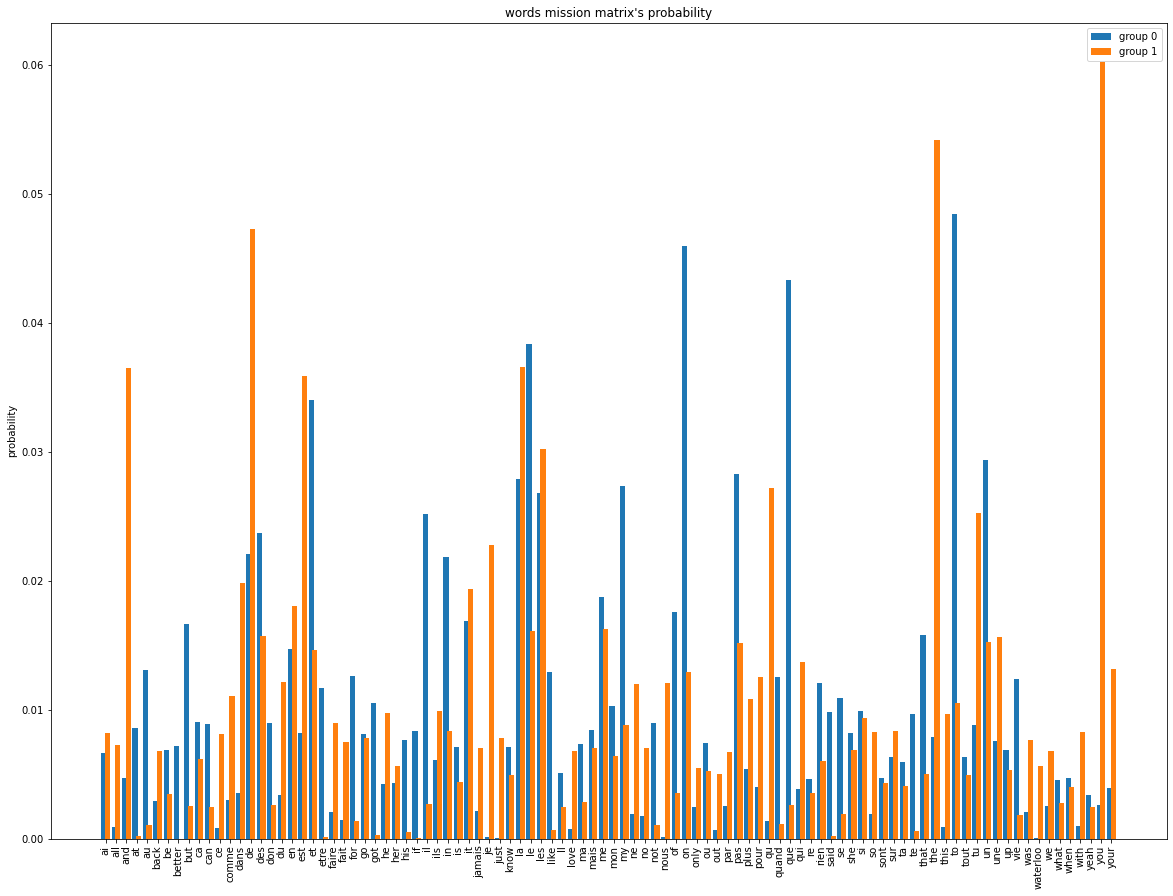

In [24]:
plot_emission(HMM_word.B_, HMM_word.unique_word_.keys(), "words mission matrix's probability", fig_size = (20,15))

In [25]:
HMM_word.unique_word_.keys()

dict_keys(['ai', 'all', 'and', 'at', 'au', 'back', 'be', 'better', 'but', 'ca', 'can', 'ce', 'comme', 'dans', 'de', 'des', 'don', 'du', 'en', 'est', 'et', 'etre', 'faire', 'fait', 'for', 'go', 'got', 'he', 'her', 'his', 'if', 'il', 'ils', 'in', 'is', 'it', 'jamais', 'je', 'just', 'know', 'la', 'le', 'les', 'like', 'll', 'love', 'ma', 'mais', 'me', 'mon', 'my', 'ne', 'no', 'not', 'nous', 'of', 'on', 'only', 'ou', 'out', 'par', 'pas', 'plus', 'pour', 'qu', 'quand', 'que', 'qui', 're', 'rien', 'said', 'se', 'she', 'si', 'so', 'sont', 'sur', 'ta', 'te', 'that', 'the', 'this', 'to', 'tout', 'tu', 'un', 'une', 'up', 'vie', 'was', 'waterloo', 'we', 'what', 'when', 'with', 'yeah', 'you', 'your'])